In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
from torch.utils.data import DataLoader

import hydra

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from src.models.core_models.zero_shot_ris import ZeroShotRIS
from src.data.core_datasets.phrasecutdataset import PhraseCutDataset

In [3]:
with hydra.initialize(version_base="1.3", config_path="../conf"):
    cfg = hydra.compose(config_name="config.yaml")
cfg

{'CUDNN_BENCHMARK': False, 'DATALOADER': {'ASPECT_RATIO_GROUPING': True, 'FILTER_EMPTY_ANNOTATIONS': True, 'NUM_WORKERS': 4, 'REPEAT_THRESHOLD': 0.0, 'SAMPLER_TRAIN': 'TrainingSampler'}, 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000, 'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000, 'PROPOSAL_FILES_TEST': [], 'PROPOSAL_FILES_TRAIN': [], 'TEST': ['coco_2017_val'], 'TRAIN': ['coco_2017_train_unlabeled_densecl_r101']}, 'GLOBAL': {'HACK': 1.0}, 'INPUT': {'CROP': {'ENABLED': False, 'SIZE': [0.9, 0.9], 'TYPE': 'relative_range'}, 'FORMAT': 'RGB', 'MASK_FORMAT': 'bitmask', 'MAX_SIZE_TEST': 1333, 'MAX_SIZE_TRAIN': 1333, 'MIN_SIZE_TEST': 800, 'MIN_SIZE_TRAIN': [640, 672, 704, 736, 768, 800], 'MIN_SIZE_TRAIN_SAMPLING': 'choice', 'RANDOM_FLIP': 'horizontal'}, 'MODEL': {'ANCHOR_GENERATOR': {'ANGLES': [[-90, 0, 90]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'NAME': 'DefaultAnchorGenerator', 'OFFSET': 0.0, 'SIZES': [[32, 64, 128, 256, 512]]}, 'BACKBONE': {'FREEZE_AT': 0, 'NAME': 'build_resnet_fpn_backbone'},

In [4]:
ZeroShotRIS?

Init signature:
ZeroShotRIS(
    clip_pretrained_path,
    is_hf_model,
    solo_config,
    solo_state_dict_path,
    clip_interpolation_mode=<InterpolationMode.BICUBIC: 'bicubic'>,
) -> None
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class

In [18]:
# pretrained_path = "openai/clip-vit-base-patch32"
pretrained_path = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"

In [19]:
PHRASECUT_ROOT="/run/media/maverick/Backup/datasets/phrasecut"

In [20]:
img_size = 224
img_mean= [0.48145466, 0.4578275, 0.40821073]
img_std= [0.26862954, 0.26130258, 0.27577711] 

In [21]:
transforms = A.Compose([    
    # A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=img_mean,std=img_std),
    ToTensorV2(transpose_mask=True)
])

In [22]:
ds = PhraseCutDataset(
    data_root=PHRASECUT_ROOT,
    task_json_path="filtered_tasks/refer_train.json",
    tokenizer_pretrained_path=pretrained_path,
    transforms=transforms,
    return_tensors="pt",
    prompt_method="fixed",
    neg_prob=0
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [23]:
dl = DataLoader(ds)

In [24]:
sample = next(iter(dl))
sample

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'image': tensor([[[[-0.2594, -0.5660, -0.8580,  ..., -0.0405, -0.2448, -0.0550],
           [-0.2448, -0.5222, -0.7850,  ..., -0.1280, -0.2740, -0.1280],
           [-0.2594, -0.4930, -0.7412,  ..., -0.6974, -0.2886, -0.0842],
           ...,
           [-0.6244, -0.5806, -0.6098,  ..., -0.2302, -0.2156, -0.2302],
           [-0.6244, -0.5952, -0.6390,  ..., -0.2156, -0.2010, -0.2010],
           [-0.6098, -0.6098, -0.6682,  ..., -0.1280, -0.1134, -0.0842]],
 
          [[-0.7166, -0.9717, -1.1818,  ..., -1.3169, -1.0017, -0.8967],
           [-0.7016, -0.9267, -1.1218,  ..., -0.9867, -1.0767, -1.3319],
           [-0.7166, -0.8967, -1.0767,  ..., -1.3769, -0.8066, -0.5365],
           ...,
           [-1.0317, -0.9867, -1.0167,  ..., -0.7916, -0.7766, -0.7916],
           [-1.0317, -1.0017, -1.0467,  ..., -0.7766, -0.7616, -0.7616],
           [-1.0167, -1.0167, -1.0767,  ..., -0.6865, -0.6715, -0.6415]],
 
          [[-0.8688, -1.0394, -1.1816,  ..., -1.4518, -1.2385, -0.9967],
    

In [25]:
sample["image"].shape

torch.Size([1, 3, 300, 500])

In [26]:
sample["input_ids"].shape

torch.Size([1, 7])

In [27]:
image_input = sample["image"]
text_input = {
    "input_ids": sample["input_ids"].expand(2, -1),
    "attention_mask": sample["attention_mask"].expand(2, -1),
}

In [28]:
openclip_pretrained = "hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"

In [29]:
zsmodel = ZeroShotRIS(openclip_pretrained, False, cfg, "/run/media/maverick/Backup/checkpoints/FreeSOLO_R101_30k.pt")

In [30]:
zsmodel.eval()
with torch.inference_mode():
    output = zsmodel(image_input, text_input)

Before Masking torch.Size([1, 197, 768])
After Masking torch.Size([33, 197, 768])
Before Masking torch.Size([33, 197, 768])
After Masking torch.Size([33, 197, 768])
Before Masking torch.Size([33, 197, 768])
After Masking torch.Size([33, 197, 768])
tensor([[    2,    42,  7745,  1685, 20022,    17,     3],
        [    2,    42,  7745,  1685, 20022,    17,     3]]) torch.Size([2, 7])


In [31]:
output.shape

torch.Size([1, 300, 500])

In [32]:
from matplotlib import pyplot as plt

import numpy as np

In [33]:
np_image = sample["image"][0].movedim(0, -1).numpy()

img_mean= np.array([0.48145466, 0.4578275, 0.40821073])
img_std= np.array([0.26862954, 0.26130258, 0.27577711])

norm_image = np_image * img_std + img_mean

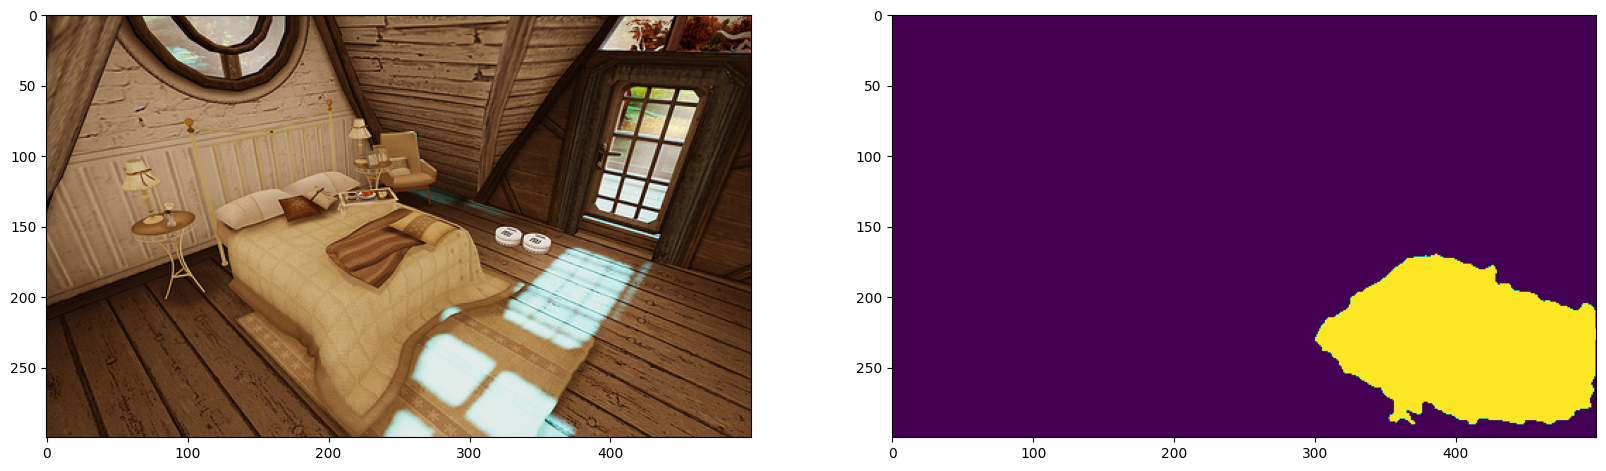

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(norm_image)
ax2.imshow(output[0])

In [35]:
def rescale_img(img):
    img_min = img.min((0, 1))
    return (img - img_min) / (img.max((0, 1)) - img_min)

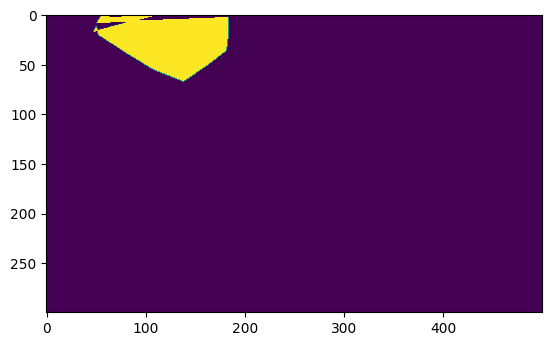

In [36]:
plt.imshow(sample["mask"].squeeze())